In [1]:
using ProgressMeter
using JLD
using Random
include("../alpcahus.jl")
#include("/home/javier/Desktop/OLD_alpcahus/alpcahus.jl")
include("../helperFunctions.jl")
include("../cluster.jl")

hungarianAlgorithm (generic function with 1 method)

In [2]:
pwd()

"/home/javier/Desktop/alpcahus/ekss"

In [4]:
D = 50 # ambient space dimension
d = 3 # subspace dimension
goodPoints = 6 # good points per subspace
ν1 = 0.1 # noise variance good points
K = 2 # subspace count
varianceRatio = range( 1,300,5) # variance ratio for heatmaps
pointRatio = range(1,50,5) # point ratio between good bad data for heatmaps
trials = 1; # smoother results
qValue = 24;

In [4]:
seedVector1 = rand(Xoshiro(1234), 1:100000, trials*length(varianceRatio)*length(pointRatio));
seedVector2 = rand(Xoshiro(4321), 1:100000, trials*length(varianceRatio)*length(pointRatio));
seedVector3 = rand(Xoshiro(2143), 1:100000, trials*length(varianceRatio)*length(pointRatio));
seedVector4 = rand(Xoshiro(3412), 1:100000, trials*length(varianceRatio)*length(pointRatio));

In [6]:
ekssTensor = zeros(length(varianceRatio), length(pointRatio),trials)
alpcahTensor = zeros(length(varianceRatio), length(pointRatio),trials)
oracleTensor = zeros(length(varianceRatio), length(pointRatio),trials)

count = 1
@showprogress 1 "Running..." for i = 1:length(varianceRatio) # varianceRatio
     for j = 1:length(pointRatio) # prepend Threads.@threads for multi-threading
        for k = 1:trials
            # other parameters
            ν2 = varianceRatio[i]*ν1
            badPoints = round(Int, pointRatio[j]*goodPoints)
            # subspace generation
            U1 = generateSubspace(D, d; seed=seedVector1[count]) 
            U2 = generateSubspace(D, d; seed=seedVector2[count])
            # data generation
            X1 = generateData(U1, [ν1,ν2], [goodPoints,badPoints]; seed=seedVector3[count])
            X2 = generateData(U2, [ν1,ν2], [goodPoints,badPoints]; seed=seedVector4[count])
            # complete data matrix
            X = hcat(X1,X2);
            # cluster assignments
            trueLabels = vec([1*ones(size(X1)[2],1); 2*ones(size(X2)[2],1)]);
            # ekss trial
            estimatedCluster = ALPCAHUS(X,K, [d;d]; B=128, q=qValue, T=3, subspaceMethod=:pca, finalStep=false)
            ekssTensor[i,j,k] = clusterError(trueLabels,estimatedCluster)
            # alpcahus trail
            estimatedCluster = ALPCAHUS(X,K, [d;d]; B=128, q=qValue, T=3, alpcahIter=20, subspaceMethod=:alpcah, finalStep=true, varfloor=1e-9, varianceMethod=:groupless) 
            alpcahTensor[i,j,k] = clusterError(trueLabels,estimatedCluster)
            # noisy oracle trial       
            noisyU1 = svd(X1[:,1:goodPoints]).U[:,1:d]
            noisyU2 = svd(X2[:,1:goodPoints]).U[:,1:d]
            estimatedCluster = clusterAssignment(X, [noisyU1, noisyU2], K)
            oracleTensor[i,j,k] = clusterError(trueLabels,estimatedCluster)
            # increase count
            count = count + 1
        end
    end
end

#save("trialData.jld", "ekss", ekssTensor, "alpcah", alpcahTensor, "oracle", oracleTensor);

Running... 100%|█████████████████████████████████████████| Time: 0:00:19


In [2]:
trialData = load("trialData.jld")
ekssTensor = trialData["ekss"]
alpcahTensor = trialData["alpcah"]
oracleTensor = trialData["oracle"];

In [6]:
generateHeatmap(pointRatio, varianceRatio, ekssTensor; plotType=:median, methodType="EKSS", ν1=ν1, goodPoints=goodPoints)
savefig("ekss_median.pdf")

"/home/javier/Desktop/alpcahus/ekss/ekss_median.pdf"

In [7]:
generateHeatmap(pointRatio, varianceRatio, alpcahTensor; plotType=:median, methodType="ALPCAHUS", ν1=ν1, goodPoints=goodPoints)
savefig("alpcahus_median.pdf")

"/home/javier/Desktop/alpcahus/ekss/alpcahus_median.pdf"

In [8]:
generateHeatmap(pointRatio, varianceRatio, oracleTensor; plotType=:median, methodType="Noisy Oracle", ν1=ν1, goodPoints=goodPoints)
savefig("oracle_median.pdf")

"/home/javier/Desktop/alpcahus/ekss/oracle_median.pdf"

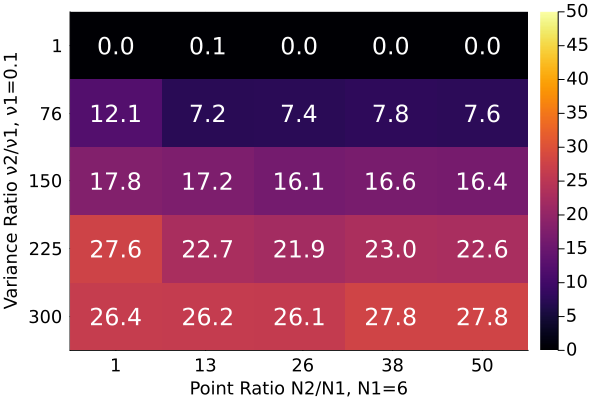

In [10]:
generateHeatmap(pointRatio, varianceRatio, alpcahTensor; plotType=:mean, methodType="ALPCAHUS", ν1=ν1, goodPoints=goodPoints)
#savefig("alpcahus_mean.pdf")

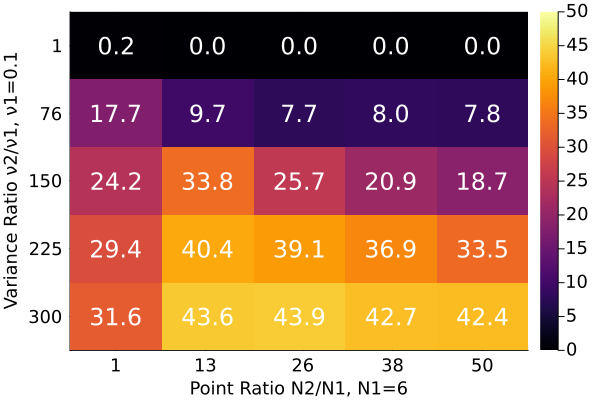

In [7]:
generateHeatmap(pointRatio, varianceRatio, ekssTensor; plotType=:mean, methodType="EKSS", ν1=ν1, goodPoints=goodPoints)
#savefig("ekss_mean.pdf")

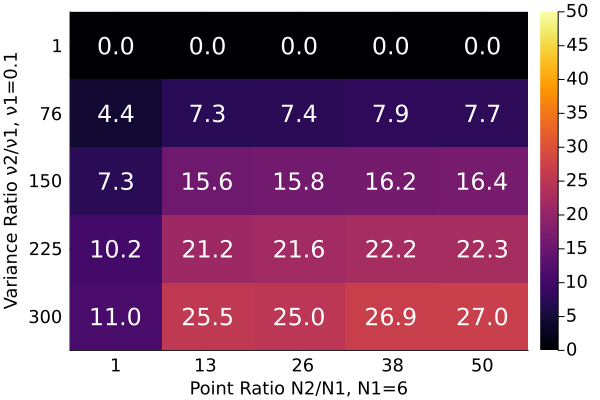

In [13]:
generateHeatmap(pointRatio, varianceRatio, oracleTensor; plotType=:mean, methodType="Noisy Oracle", ν1=ν1, goodPoints=goodPoints)
#savefig("oracle_mean.pdf")

In [12]:
generateHeatmap(pointRatio, varianceRatio, ekssTensor; plotType=:variance, methodType="EKSS", ν1=ν1, goodPoints=goodPoints)
savefig("ekss_variance.pdf")

"/home/javier/Desktop/alpcahus/ekss/ekss_variance.pdf"

In [13]:
generateHeatmap(pointRatio, varianceRatio, alpcahTensor; plotType=:variance, methodType="ALPCAHUS", ν1=ν1, goodPoints=goodPoints)
savefig("alpcahus_variance.pdf")

"/home/javier/Desktop/alpcahus/ekss/alpcahus_variance.pdf"

In [14]:
generateHeatmap(pointRatio, varianceRatio, oracleTensor; plotType=:variance, methodType="Noisy Oracle", ν1=ν1, goodPoints=goodPoints)
savefig("oracle_variance.pdf")

"/home/javier/Desktop/alpcahus/ekss/oracle_variance.pdf"